In [1]:
# Multi-layer Perceptron regressor.

import numpy as np
import pandas as pd
from math import sqrt


import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split,cross_val_score,cross_validate
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

from sklearn.neural_network import MLPRegressor


In [4]:
# Import datasets
returns = pd.read_excel("Returns_Clean.xlsx", index_col = 'Dates')
returns.index = pd.to_datetime(returns.index, format='%Y%m%d')

flows = pd.read_excel("Flows_Clean.xlsx", index_col = 'Dates')
flows.index = pd.to_datetime(flows.index, format='%Y%m%d')

returns_labeled = returns.copy()
returns_labeled.columns =['return_'+str(i) for i in returns.columns]
flows_labeled = flows.copy()
flows_labeled.columns = ['flow_'+str(i) for i in flows.columns]

print(returns_labeled.head())
print(flows_labeled.head())

            return_55976  return_41072  return_27748  return_75259  \
Dates                                                                
1993-04-01     -0.019685      0.019391     -0.007282     -0.003891   
1993-04-02     -0.020080      0.002717     -0.002445      0.058594   
1993-04-05     -0.024590     -0.006775     -0.002451      0.022140   
1993-04-06     -0.067227      0.009550     -0.007371      0.025271   
1993-04-07      0.000000      0.005405      0.000000      0.021127   

            return_40970  return_62519  return_21792  return_54084  \
Dates                                                                
1993-04-01      0.083333      0.027027      0.005348      0.020000   
1993-04-02     -0.038462     -0.026316     -0.007979     -0.019608   
1993-04-05     -0.040000      0.027027      0.005362      0.000000   
1993-04-06      0.041667      0.052632      0.005333      0.000000   
1993-04-07      0.040000     -0.050000      0.002653      0.000000   

            return

In [3]:
# Preprocessing the datasets

# the combine of returns and flows of stocks
S = pd.concat([returns, flows], axis = 1)
S_labeled = pd.concat([returns_labeled, flows_labeled], axis = 1)
# print(S.describe())

# Standardize the dataset
scaler = StandardScaler()
returns_scaled = pd.DataFrame(scaler.fit_transform(returns), columns =returns.columns)
flows_scaled = pd.DataFrame(scaler.fit_transform(flows), columns =flows.columns)
# print(returns_scaled.describe())
# print(flows_scaled.describe())

S_scaled = pd.concat([returns_scaled, flows_scaled], axis = 1)
# print(S_scaled.describe())

In [21]:
# Using the equally-weighted portfolio consisting with all 100 stocks to demonstrate the model
# The portfolio returns and flows are the average of all stocks
port_returns = pd.DataFrame(data = returns.mean(axis=1), columns = ['Portfolio_returns'] )
# print(port_returns.head())
port_flows = pd.DataFrame(data = flows.mean(axis = 1), columns = ['Portfolio_flows'])
# port_flows.head()
portfolio = pd.concat([port_returns, port_flows], axis = 1)
# generate predictor matrix for portfolio
# predictor matrix P_small, includes portfolio's own returns up to three lags and portfolio’s net trading flows up to three lags

P_full = pd.read_excel("Portfolio_features_extraction_using_full_LASSO.xlsx", index_col = 'Dates')

py = port_returns
# split the training and test dataset using X_full
# P_train, P_test, py_train, py_test = train_test_split(P_full, py.values.ravel(), test_size=0.2, random_state=0, shuffle = False)
# print(py.shape)


DatetimeIndex(['1993-04-01', '1993-04-02', '1993-04-05', '1993-04-06',
               '1993-04-07', '1993-04-08', '1993-04-12', '1993-04-13',
               '1993-04-14', '1993-04-15',
               ...
               '2000-12-15', '2000-12-18', '2000-12-19', '2000-12-20',
               '2000-12-21', '2000-12-22', '2000-12-26', '2000-12-27',
               '2000-12-28', '2000-12-29'],
              dtype='datetime64[ns]', name='Dates', length=1958, freq=None)


In [31]:
# rolling window

window_size = 252
dates = []
grid_models_p = []
grid_predict = []
grid_y_test = []
historical_mean = []
grid_mse_p = []
grid_rmse_p = []

for n in tqdm(range(1, len(portfolio)-window_size-1)):
    dates.append(portfolio.index[n])
    n_train = P_full.iloc[n:n+window_size]
    n_test = P_full.iloc[n+window_size+1]
    ny_train = py.iloc[n:n+window_size]
    ny_test = py.iloc[n+window_size+1]

#   Grid search for optimal hyperparameter
#     layer_size = [(100,)]
    layer_size = [(ls,) for ls in range(100,500,100)]
#     activation_option = ['tanh', 'relu']
    activation_option = ['tanh']
    solver_option = ['lbfgs']
#     solver_option = ['adam','lbfgs']
    para_grid = {'hidden_layer_sizes': layer_size, 'activation': activation_option, 'solver': solver_option}
    #     MLPR model with cross-validation of 5-fold
    MLPR = MLPRegressor(alpha = 0.0001, max_iter = 1000, shuffle = False)
    grid = GridSearchCV(MLPR, para_grid, cv = 5)
    grid.fit(n_train, ny_train.values.ravel())
    grid_models_p.append(grid)
#     Rolling window prediction
    ny_pred = grid.predict(n_test.values.reshape(1,-1))
    grid_predict.append(ny_pred[0])
    grid_y_test.append(ny_test[0])
    historical_mean.append(ny_train.mean()[0])
#     MSE and RMSE
    mse = mean_squared_error(ny_pred, ny_test)
    grid_mse_p.append(mse)
    rmse = sqrt(mse)
    grid_rmse_p.append(rmse)
    



In [32]:
result_p = pd.DataFrame(list(zip(dates,grid_models_p, grid_predict, grid_y_test, historical_mean,grid_mse_p, grid_rmse_p)), columns=['Date','Grid-MLPR models','Predicted Returns','Portfolio Returns', 'Historical Mean', 'MSE','RMSE'])
result_p['diff_SSE'] = (result_p['Historical Mean'] - result_p['Portfolio Returns'])**2 - (result_p['Predicted Returns'] - result_p['Portfolio Returns'])**2
result_p['Cum_SSE'] = np.cumsum(result_p.diff_SSE) 
print(result_p.head())
result_p.to_excel('Grid-MLPR_portfolio_results.xlsx', index = False)


        Date                                   Grid-MLPR models  \
0 1993-04-02  GridSearchCV(cv=5, estimator=MLPRegressor(max_...   
1 1993-04-05  GridSearchCV(cv=5, estimator=MLPRegressor(max_...   
2 1993-04-06  GridSearchCV(cv=5, estimator=MLPRegressor(max_...   
3 1993-04-07  GridSearchCV(cv=5, estimator=MLPRegressor(max_...   
4 1993-04-08  GridSearchCV(cv=5, estimator=MLPRegressor(max_...   

   Predicted Returns  Portfolio Returns  Historical Mean       MSE      RMSE  \
0          -1.153799          -0.011868         0.000463  1.304005  1.141931   
1           0.441315           0.023475         0.000515  0.174591  0.417841   
2          -0.260754           0.003069         0.000453  0.069602  0.263823   
3           0.157680           0.005718         0.000559  0.023092  0.151962   
4          -0.241178          -0.008421         0.000575  0.054176  0.232757   

   diff_SSE   Cum_SSE  
0 -1.303853 -1.303853  
1 -0.174064 -1.477917  
2 -0.069596 -1.547512  
3 -0.023066 -1.57057

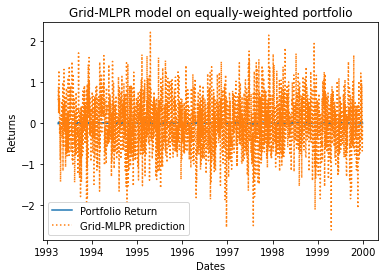

In [28]:
plt.figure()
plt.plot(result_p['Date'], result_p['Portfolio Returns'],  label = 'Portfolio Return')
plt.plot(result_p['Date'], result_p['Predicted Returns'], ':', label = 'Grid-MLPR prediction')

plt.legend()

plt.xlabel('Dates')
plt.ylabel('Returns')
plt.title('Grid-MLPR model on equally-weighted portfolio')
plt.show()

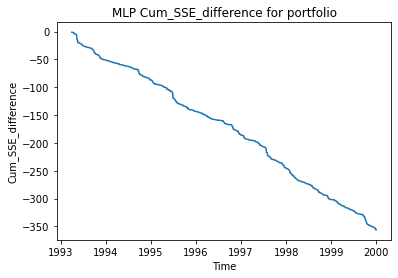

In [33]:
plt.figure()
plt.plot(result_p['Date'], result_p['Cum_SSE'])

# plt.legend()

plt.xlabel('Time')
plt.ylabel('Cum_SSE_difference')
plt.title('MLP Cum_SSE_difference for portfolio')
plt.axis('tight')
plt.show()

In [34]:
min_rmse = min(grid_rmse_p)
min_index = grid_rmse_p.index(min_rmse)
best_MLPR = grid_models_p[min_index]
print(best_MLPR.best_params_)

print(best_MLPR.cv_results_)


{'activation': 'tanh', 'hidden_layer_sizes': (100,), 'solver': 'lbfgs'}
{'mean_fit_time': array([0.17877793, 0.2122333 , 0.2449605 , 0.34426064]), 'std_fit_time': array([0.02029708, 0.04182118, 0.02900547, 0.06646604]), 'mean_score_time': array([0.00275178, 0.00349011, 0.0028626 , 0.00356903]), 'std_score_time': array([0.00050201, 0.00085561, 0.00033938, 0.00051516]), 'param_activation': masked_array(data=['tanh', 'tanh', 'tanh', 'tanh'],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'param_hidden_layer_sizes': masked_array(data=[(100,), (200,), (300,), (400,)],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'param_solver': masked_array(data=['lbfgs', 'lbfgs', 'lbfgs', 'lbfgs'],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'activation': 'tanh', 'hidden_layer_sizes': (100,), 'solver': 'lbfgs'}, {'activation': 'tanh', 'hid